## 0. Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel, TFAlbertModel, TFElectraModel, TFDistilBertModel, DistilBertModel
from transformers import ElectraTokenizer, BertTokenizerFast

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
strategy = tf.distribute.get_strategy()

## 1. Load Dataset

In [3]:
train = pd.read_csv("../dataset/train.csv", encoding='CP949')
test = pd.read_csv("../dataset/test.csv", encoding='CP949')

## 2. EDA

### 2.1. LabelEncoder을 통해 str형태의 label을 숫자로 변환

In [4]:
categorical_cols = ['label']
for e in categorical_cols:
    le = LabelEncoder()
    train[e] = le.fit_transform(train[e])

In [5]:
train.head()

,index,premise,hypothesis,label
0,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,0
1,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,1
2,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,2
3,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,2
4,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,1


### 훈련 데이터의 결측치 확인

In [6]:
train.isnull().sum()

index         0
premise       0
hypothesis    0
label         0
dtype: int64

### 클래스의 불균형이 있는지 시각화하여 확인

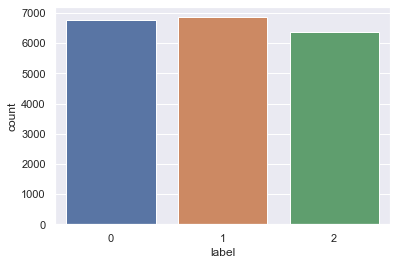

In [7]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

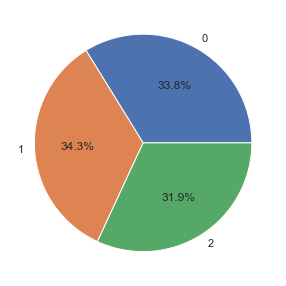

In [8]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

## 3. Modeling

최종 목표인 Stacking Ensemble을 적용하기 위해서 개별 모델 3가지를 구현했습니다.  
각각 사전학습된 ELECTRA, BERT, ALBERT 모델에 대해 fine-tune을 적용했습니다.  
이전 electra 개별 모델 구현 파일에서 토크나이징 후 조정할 패딩의 길이를 100으로 정했습니다.  
따라서, 각각의 모델들의 input_layer의 shape을 (100,)으로 지정했습니다.  

### 3.1 개별 모델 구현 함수

In [ ]:
def model_KoELECTRA():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def model_BERT():
    with strategy.scope():
        encoder = TFBertModel.from_pretrained("kykim/bert-kor-base")

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def model_ALBERT():
    with strategy.scope():
        encoder = TFAlbertModel.from_pretrained("kykim/albert-kor-base")

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

### 3.2 구현한 모델, 토크나이저 선언

In [10]:
model_bert = model_BERT()
model_albert = model_ALBERT()
model_electra = model_KoELECTRA()

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at kykim/bert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
All model checkpoint layers were used when initializing TFAlbertModel.

All the layers of TFAlbertModel were initialized from the model checkpoint at kykim/albert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['electra.embeddings.position_ids', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

In [11]:
tokenizer_bert = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
tokenizer_albert = BertTokenizerFast.from_pretrained("kykim/albert-kor-base")
tokenizer_electra = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

### 3.3 훈련 데이터 전처리

훈련데이터에 대해 각 문장에 대한 인코딩을 수행하고 패딩을 맞춰주는 전처리 작업을 진행합니다.  
훈련데이터를 7:3 비율로 훈련데이터와 검증데이터를 나눕니다.  
검증데이터는 각 개별 모델로 예측을 진행하고, 클래스에 대한 예측 확률 값들과 예측 클래스 값들을 통해 앙상블 데이터로 사용하게 됩니다.  
따라서, 최종 제출할 대상이 되는 테스트 데이터에 대해서도 예측을 하고 예측 확률 값들과 클래스를 저장하는 같은 과정을 거치게 됩니다.  

In [12]:
train_data = train[['premise', 'hypothesis']].values.tolist()
test_data = test[['premise', 'hypothesis']].values.tolist()

#### 3.3.1 ELECTRA 모델링

In [13]:
train_encoded_electra = tokenizer_electra.batch_encode_plus(train_data, padding='max_length', max_length=100)
test_encoded_electra = tokenizer_electra.batch_encode_plus(test_data, padding='max_length', max_length=100)

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra['input_ids'], train.label.values, test_size=0.3, shuffle=False)
x_test = test_encoded_electra['input_ids']

In [15]:
# x_train, y_train = train_encoded_electra['input_ids'], train.label.values
# x_test = test_encoded_electra['input_ids']

In [16]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [17]:
history_electra = model_electra.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                                     validation_data=valid_dataset,epochs= 3)

Epoch 1/3
999/999 [==============================] - 385s 378ms/step - loss: 0.5184 - accuracy: 0.7837 - val_loss: 0.4014 - val_accuracy: 0.8570
Epoch 2/3
999/999 [==============================] - 375s 375ms/step - loss: 0.2313 - accuracy: 0.9172 - val_loss: 0.4548 - val_accuracy: 0.8635
Epoch 3/3
999/999 [==============================] - 375s 375ms/step - loss: 0.1124 - accuracy: 0.9635 - val_loss: 0.5173 - val_accuracy: 0.8656


In [18]:
# history_electra = model_electra.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
#                                     epochs= 3)

In [19]:
electra_pred = model_electra.predict(x_valid, verbose=1)
electra_pred_class = np.argmax(electra_pred, axis=1)

188/188 [==============================] - 28s 148ms/step


In [21]:
test_pred_electra = model_electra.predict(test_dataset, verbose=1)
test_pred_electra_class = np.argmax(test_pred_electra, axis=1)

250/250 [==============================] - 26s 104ms/step


#### 3.3.2 BERT, ALBERT 모델링

In [22]:
train_encoded_bert = tokenizer_bert.batch_encode_plus(train_data, padding='max_length', max_length=100)
test_encoded_bert = tokenizer_bert.batch_encode_plus(test_data, padding='max_length', max_length=100)

In [23]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_bert['input_ids'], train.label.values, test_size=0.3, shuffle=False)
x_test = test_encoded_bert['input_ids']

In [24]:
# x_train, y_train = train_encoded_bert['input_ids'], train.label.values
# x_test = test_encoded_bert['input_ids']

In [25]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [26]:
history_bert = model_bert.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                              validation_data=valid_dataset, epochs= 3)

history_albert = model_albert.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                                  validation_data=valid_dataset, epochs= 3)

Epoch 1/3
999/999 [==============================] - 400s 392ms/step - loss: 0.6827 - accuracy: 0.7061 - val_loss: 0.5025 - val_accuracy: 0.8118
Epoch 2/3
999/999 [==============================] - 384s 385ms/step - loss: 0.3488 - accuracy: 0.8702 - val_loss: 0.5261 - val_accuracy: 0.8211
Epoch 3/3
999/999 [==============================] - 299s 299ms/step - loss: 0.1830 - accuracy: 0.9350 - val_loss: 0.6903 - val_accuracy: 0.8245
Epoch 1/3
999/999 [==============================] - 305s 293ms/step - loss: 0.7425 - accuracy: 0.6624 - val_loss: 0.5737 - val_accuracy: 0.7741
Epoch 2/3
999/999 [==============================] - 290s 291ms/step - loss: 0.3636 - accuracy: 0.8640 - val_loss: 0.6125 - val_accuracy: 0.7883
Epoch 3/3
999/999 [==============================] - 292s 293ms/step - loss: 0.1378 - accuracy: 0.9529 - val_loss: 0.8724 - val_accuracy: 0.7843


In [27]:
bert_pred = model_bert.predict(x_valid, verbose=1)
albert_pred = model_albert.predict(x_valid)

188/188 [==============================] - 28s 144ms/step


In [28]:
bert_pred_class = np.argmax(bert_pred, axis=1)
albert_pred_class = np.argmax(albert_pred, axis=1)

In [29]:
test_pred_bert = model_bert.predict(test_dataset, verbose=1)
test_pred_albert = model_albert.predict(test_dataset, verbose=1)

test_pred_bert_class = np.argmax(test_pred_bert, axis=1)
test_pred_albert_class = np.argmax(test_pred_albert, axis=1)

250/250 [==============================] - 36s 146ms/step


In [30]:
# print('bert 정확도: {0:.4f}'.format(accuracy_score(y_valid, bert_pred_class)))
# print('albert 정확도: {0:.4f}'.format(accuracy_score(y_valid, albert_pred_class)))

## 4. Stacking Ensemble learning

이전에 구했었던 검증 데이터에 대해 개별 모델로 예측한 메타데이터를 생성하여 스태킹 앙상블에 대한 훈련 데이터를 만들었습니다.  
또한, 최종 예측할 테스트 데이터에 대한 개별 모델 예측 메타데이터도 생성했습니다.  
만들어진 메타 데이터 학습을 하며 Stacking 앙상블을, 최종 판별 모델을 XGBoost를 사용하며 Boosting 앙상블을 적용했습니다.  
이렇게 만들어진 XGBoost 모델을 통해 테스트 메타 데이터에 똑같이 적용함으로써 최종 예측을 진행했습니다.  

### 4.1 메타 데이터 생성

In [31]:
meta_data = np.array([
    np.transpose(electra_pred)[0], np.transpose(electra_pred)[1], np.transpose(electra_pred)[2], electra_pred_class,
    np.transpose(bert_pred)[0], np.transpose(bert_pred)[1], np.transpose(bert_pred)[2], bert_pred_class,
    np.transpose(albert_pred)[0], np.transpose(albert_pred)[1], np.transpose(albert_pred)[2], albert_pred_class
])
print(meta_data.shape)

(12, 5999)


In [32]:
meta_data = np.transpose(meta_data)
print(meta_data.shape)

(5999, 12)


### 4.2 XGBoost Modeling

In [33]:
from xgboost import XGBClassifier

xgb_final = XGBClassifier(silent=False,
                          n_estimators = 10000,
                          booster='gbtree',
                          tree_method='gpu_hist',
                          preidctor= 'gpu_predictor',
                          learning_rate=0.02,
                          objective='multi:softmax',
                          max_depth = 8,
                          subsample = 0.8,
                          random_state=42)

In [34]:
final_model = xgb_final.fit(meta_data, y_valid)

[12:29:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:29:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [35]:
final = final_model.predict(meta_data)

In [36]:
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_valid , final)))

최종 메타 모델의 예측 정확도: 1.0000


In [37]:
final

array([2, 1, 2, ..., 1, 2, 1])

In [38]:
len(final)

5999

### 4.3 최종 예측 메타 데이터 생성 및 최종 판별 진행

In [41]:
test_meta_data = np.array([
    np.transpose(test_pred_electra)[0], np.transpose(test_pred_electra)[1], np.transpose(test_pred_electra)[2], test_pred_electra_class,
    np.transpose(test_pred_bert)[0], np.transpose(test_pred_bert)[1], np.transpose(test_pred_bert)[2], test_pred_bert_class,
    np.transpose(test_pred_albert)[0], np.transpose(test_pred_albert)[1], np.transpose(test_pred_albert)[2], test_pred_albert_class
])
print(meta_data.shape)

(12, 5000)


In [46]:
test_meta_data = np.transpose(test_meta_data)
print(meta_data.shape)

(12, 5000)


In [47]:
predictions = final_model.predict(test_meta_data)

In [48]:
predictions

array([0, 1, 0, ..., 2, 0, 0])

In [49]:
list1 = [i for i in range(5000)]

In [51]:
list2 = predictions

In [52]:
submission = pd.DataFrame({'index':list1,
                           'label':list2})

In [53]:
submission

,index,label
0,0,0
1,1,1
2,2,0
3,3,1
4,4,2
...,...,...
4995,4995,2
4996,4996,0
4997,4997,2
4998,4998,0


In [54]:
# contradiction => 0 entailment => 1 neutral => 2
submission['label'].replace(0, 'contradiction', inplace=True)
submission['label'].replace(1, 'entailment', inplace=True)
submission['label'].replace(2, 'neutral', inplace=True)

## 5. versus Previous submission

리더보드에 올렸던 88%의 탐지율을 달성했던 csv파일과 유사도 비교를 진행했습니다.  
유사도가 90%이며, 성능이 어느 정도 올라갈 것이라는 판단을 할 수 있습니다.

In [55]:
previous = pd.read_csv('../submission/submission_KoELECTRAv4.csv')

In [56]:
previous['label']

0       contradiction
1          entailment
2       contradiction
3          entailment
4             neutral
            ...      
4995          neutral
4996    contradiction
4997          neutral
4998    contradiction
4999    contradiction
Name: label, Length: 5000, dtype: object

In [57]:
submission['label']

0       contradiction
1          entailment
2       contradiction
3          entailment
4             neutral
            ...      
4995          neutral
4996    contradiction
4997          neutral
4998    contradiction
4999    contradiction
Name: label, Length: 5000, dtype: object

In [58]:
cnt_equal = 0
cnt_diff = 0
for i in range(5000):
    if previous['label'][i] == submission['label'][i]:
        cnt_equal += 1
    else: cnt_diff += 1

similarity = cnt_equal/(cnt_equal+cnt_diff) * 100
print(f"이전 제출 파일과의 유사도:{similarity}%")

이전 제출 파일과의 유사도:90.44%


In [59]:
submission.to_csv("../submission/submission_stacking_v1.csv", index = False)

In [ ]:
# model.save('competition_stacking_v1.h5')
# Load model code
# new_model = tf.keras.models.load_model('competition_stacking_v1.h5')
# test_loss, test_acc = new_model.evaluate(x,  y, verbose=2)